## Chargement des packages

In [1]:
import lsst.daf.persistence as dp
import lsst.afw.display as display
import lsst.afw.display.rgb as rgb
import lsst.geom as geom

import numpy as np
import os, glob
import math

from optparse import OptionParser

import mysql
from mysql.connector import Error

import pandas as pd
from tifffile import imread, imwrite

import matplotlib.cm as cm
from matplotlib import pylab as plt

## Definition des fonctions

In [2]:
def checkPatch(tract, patch, butler):
    # Detect incomplete patches located at the border of the DC2 footprint
    # Detection is based on the number of detected sources
    goodImage = True
    patchName = str(patch[0]) + ',' + str(patch[1])
    dataId = {'tract':tract, 'patch':patchName, 'filter':'r'}
    try:
        src = butler.get('deepCoadd_forced_src', dataId=dataId)
    except Exception as msg:
        print(msg)
        goodImage = False

    if goodImage and len(src) < 10000:
        goodImage = False
        print("Incomplete image detected for tract={} - patch={}".format(tract, patch))

    return goodImage

In [3]:
def getHalos(raMin, raMax, decMin, decMax, zMax, massMin):
    # Initialize connection to qserv
    conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040) 
    cursor = conn.cursor(dictionary=True, buffered=True) 

    # Buil SQL query
    query = "SELECT data.coord_ra, data.coord_dec, data.halo_mass, data.redshift, data.Mag_true_z_lsst_z0, data.is_central, data.halo_id "
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE scisql_s2PtInBox(data.coord_ra, data.coord_dec, {raMin}, {decMin}, {raMax}, {decMax}) = 1 "
    query += f"AND data.halo_mass>{massMin} AND data.redshift<{zMax} "
    query += ";"

    #Execute Qserv query et get result in a panda dataframe
    tab = pd.read_sql_query(query,conn)

    return tab

In [4]:
def getFullImage(butler, tract, patch, innerBbox):
    # Get the 6 band image corresponding to a given tract, patch
    patchName = str(patch[0]) + ',' + str(patch[1])
    dataId = {'tract':tract, 'patch':patchName}
    im = {}
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    isBad = False
    for f in filters:
        dataId['filter'] = f
        try:
            exp = butler.get('deepCoadd', dataId=dataId).getMaskedImage()[innerBbox]
        except Exception as msg:
            print(msg)
            isBad = True
            break

        im[f] = exp.getImage().getArray()
        # We need to keep the reference coordinates X0, Y0 to convert image coordinates into natural CCD coordinates
        if f == 'r':
            X0 = exp.getX0()
            Y0 = exp.getY0()

    if not isBad:
        #Images have pixels with negative values so we add a pedestal in order to have only positive pixels 
        minVal = np.min([np.min(im[f]) for f in filters])
        if minVal < 0:
            pedestal = math.ceil(-minVal)
        else:
            pedestal = 0

        fullImage = np.dstack([im[f] + pedestal for f in filters])

        # If everything has been done correctly the overlap region should have been removed around
        # the patch and the image should be 4000x4000 pixels
        # If not, just print out a warning
        numPix = im['r'].shape[1]
        if numPix != 4000:
            print("Unexpected number of pixels in image {}".format(numPix))
    else:
        fullImage = [],
        X0 = -99
        Y0 = -99

    return fullImage, X0, Y0, isBad

In [5]:
def getSkyBbox(halos, minGal):
    # Determine bounding box containing all the halo members

    # The following 102 halo_ids correspond to badly allocated halo fragments resulting in unphysical overlapping halos. They need to be ignored 
    bad_halos = [6000141293, 360200141293, 796200182347, 211200182347, 43900177421, 105200177421, 770300055331, 889800055331, 371700158392, 
                 188200158392, 35700164347, 147900164347, 1594400179300, 1770700179300, 46800066421, 203600066421, 700156401, 177000156401, 
                 1024800140307, 755300140307, 79400164355, 377800164355, 90200163338, 96600163338, 719800156331, 653000156331, 167900142421, 
                 55300142421, 192400137401, 101900137401, 455300072355, 385900072355, 237200108411, 53800108411, 182200154373, 61400154373, 
                 292700141373, 536900141373, 281100128382, 114300128382, 1986200129293, 1148100129293, 523900115382, 175100115382, 587300129307, 
                 1582600129307, 499100113382, 23700113382, 715300097347, 486600097347, 336500043382, 28600043382, 1220300114293, 210600114293, 
                 757400098338, 562900098338, 445500110355, 301800110355, 146000071293, 966700071293, 727900096338, 249600096338, 1227200113293, 
                 1228400113293, 845000093300, 411000093300, 199400099365, 107400099365, 302200046323, 1117200046323, 149400078392, 144400078392, 
                 519000099331, 398000099331, 582700080355, 273300080355, 132700048382, 289700048382, 386000046382, 101100046382, 1862600043293, 
                 953500043293, 467300072365, 357100072365, 181800048382, 514100048382, 1144700047338, 80000047338, 145900047347, 177600047347, 
                 564400033323, 397900033323, 1210400078293, 182500078293, 1018500071307, 530600071307, 438000069307, 138300069307, 714200041331, 
                 1016500041331, 175900046323, 1103000046323]

    reject = False
    z = halos.groupby(['halo_id'])
    skyBbox = []
    for halo, df in z:
        if len(df) < minGal : # request a minimum number of galaxy members in the halo
            continue
        if halo in bad_halos:
            print("rejected halo: {}".format(halo))
            reject = True
            break
        min = geom.SpherePoint(df.coord_ra.min()*geom.degrees, df.coord_dec.min()*geom.degrees)
        max = geom.SpherePoint(df.coord_ra.max()*geom.degrees, df.coord_dec.max()*geom.degrees)
        #print(halo, df.halo_id.to_list()[0], min, max, df.redshift.to_list()[0], df.halo_mass.to_list()[0]*1.e-14)
        skyBbox.append([halo, min, max])

    return skyBbox, reject

In [6]:
def crop(x):
    # crop bounding box coordinates in order to stay within the 0-3999 range
    if (x<0):
        x = 0
    elif (x>3999):
        x = 3999
    return x


## Chargement des données

In [7]:
minGal = 5  # Minimum number of galaxy members in halos
massMin = 1.e14 # Minimum halo mass in Msun
zMax = 1.3   # Maximum redshift

e = 5        # Number of pixels to be added to the bounding box containing the galaxy cluster

numPix = 4000 # Number of pixels per line / column

# Get a gen2 butler to access the DC2 dataset 
repo = "/sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1"
butler = dp.Butler(repo)

/tmp/ipykernel_5111/4053302345.py:13: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dp.Butler(repo)
/tmp/ipykernel_5111/4053302345.py:13: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dp.Butler(repo)


lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib

In [8]:
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)
print("Found {} tracts in repo {}".format(num_tracts, repo))

Found 173 tracts in repo /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1


In [9]:
skyMap = butler.get("deepCoadd_skyMap")

In [10]:
tract = 4226
patch = (6,4)

In [11]:
tractInfo = skyMap[tract]
patches = sorted([os.path.basename(x) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', str(tract), '*'))])
print("Found {} patches in tract {}".format(len(patches), tract))
patchInfo = tractInfo.getPatchInfo(patch)   
goodImage = checkPatch(tract, patch, butler)

Found 49 patches in tract 4226


In [12]:
poly = patchInfo.getInnerSkyPolygon(tractInfo.getWcs())
wcs = tractInfo.getWcs()
vertices = poly.getVertices()
boxRa = []
boxDec = []
for pt in poly.getVertices():
    boxRa.append(geom.SpherePoint(pt).getRa().asDegrees())
    boxDec.append(geom.SpherePoint(pt).getDec().asDegrees())

raMin = np.min(boxRa)
raMax = np.max(boxRa)
decMin = np.min(boxDec)
decMax = np.max(boxDec)

halos = getHalos(raMin, raMax, decMin, decMax, zMax, massMin)

z = halos.groupby(['halo_id'])

skyBbox, reject = getSkyBbox(halos, minGal)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_07/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/pandas/io/sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
patchName = str(patch[0]) + ',' + str(patch[1])
name = str(tract) + '_' + patchName

imageFile = "/sps/lsst/users/boutigny/ML/DC2/images/"+str(tract)+"_"+str(patch[0])+","+str(patch[1])+".tif"
labelFile = "/sps/lsst/users/boutigny/ML/DC2/labels/"+str(tract)+"_"+str(patch[0])+","+str(patch[1])+".txt"

innerBbox = patchInfo.getInnerBBox()
fullImage, X0, Y0, isBad = getFullImage(butler, tract, patch, innerBbox)

24000


### Création des box comme dans script annotateDC2.py

In [15]:
# liste avec les x0 et y0
df_box = []

# liste telle que dans les fichiers
df_labels = []
    
if len(skyBbox) > 0:
    for sky in skyBbox:
        box = wcs.skyToPixel(sky[1:])
        x0 = crop(box[0].getX()-X0+e)
        y0 = crop(numPix-1 - (box[0].getY()-Y0-e))
        x1 = crop(box[1].getX()-X0-e)
        y1 = crop(numPix-1 - (box[1].getY()-Y0+e))
        dx = x0 - x1
        dy = y0 - y1
        df_box.append([sky[0], x0, x1, (numPix-1)-y0, (numPix-1)-y1])
        df_labels.append([sky[0], x1/(numPix-1), y1/(numPix-1), dx/(numPix-1), dy/(numPix-1)])

D = {halo:(x0, x1, y0, y1) for halo, x0, x1, y0, y1 in df_box}
L = {halo:(x0, x1, y0, y1) for halo, x0, x1, y0, y1 in df_labels}
labels = pd.DataFrame(df_labels)

In [16]:
##### Filtres #####
filters = ['u', 'g', 'r', 'i', 'z', 'y'] # filters list

red = 'i'
green = 'r'
blue = 'g'

In [17]:
##### fixation des paramètres ####
best_Q = 8
best_min = np.max([np.min(fullImage[:,:,filters.index(f)]) for f in filters])
best_dr  = 1.5

In [18]:
##### Transformation des donnees en rgb ####
rgb_im = rgb.makeRGB(fullImage[:,:,filters.index(red)], fullImage[:,:,filters.index(green)], fullImage[:,:,filters.index(blue)], Q = best_Q, minimum = best_min, dataRange = best_dr,
                       xSize=None, ySize=None)

Hors box
halo :  8400079442
max :  471.99239729181863
min :  0
D :  (463.80546148412395, 0, 120.29602045925458, 3352.4907915405092)
galX :  [272.8279964318426, 364.18774302684324, 136.6378456663806, 0, 149.1348658275565, 471.99239729181863, 448.7445456200003]


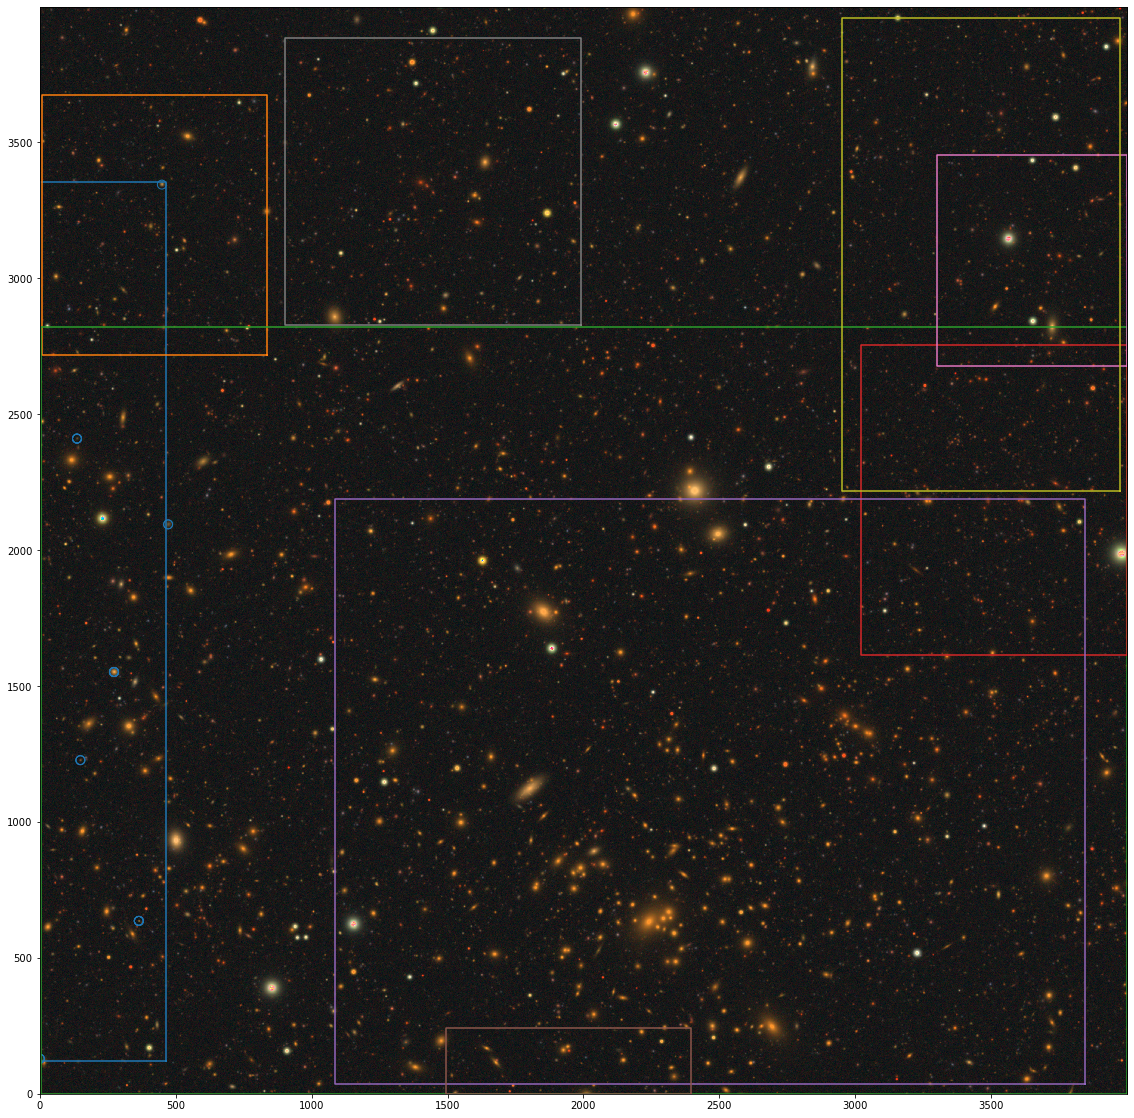

In [22]:
###### Affichage de l'image #####

colors = cm.tab10(np.linspace(0, 1, 10)) # Definition des couleurs

# Display Image
display.setDefaultBackend("matplotlib")
fig = plt.figure(figsize=(20, 20))
disp = rgb.displayRGB(rgb_im, show=False)

# Ouverture des labels si le fichier existe
try:
    labels = pd.read_csv(labelFile, header=None, sep = " ")

    # Ajout des box sur le graphe
    for box, c in zip(labels.iterrows(), colors):
        # Redimensionnement des coordonnees a la taille de l'image
        box =  [i*(numPix-1) for i in box[1]]   
        X = [box[1]+box[3], box[1]+box[3], box[1], box[1], box[3]+box[1]]
        Y = [(numPix-1)-box[2]-box[4], (numPix-1)-box[2], (numPix-1)-box[2], (numPix-1)-box[2]-box[4], (numPix-1)-box[2]-box[4]]
        disp.plot(X,Y, color=c)
except:
        print("No label file found")
        
count = 0
for halo, df in z:
    if halo == 8400079442:
        if len(df) < 5 :
            continue
        c = colors[count]
        count += 1
        galX = []
        galY = []
        for k in range(len(df)):
            p = geom.SpherePoint(list(df.coord_ra)[k]*geom.degrees, list(df.coord_dec)[k]*geom.degrees)
            galX.append(crop(wcs.skyToPixel(p).getX()-X0))
            galY.append(crop(wcs.skyToPixel(p).getY()-Y0))
            disp.scatter(galX, galY, s=80, facecolors='none', edgecolors=c)
        if (max(galX) > D[halo][1] or min(galX) < D[halo][1]) :
            print("Galaxie Hors box")
        print("halo : ", halo)
        print("max : ", max(galX))
        print("min : ", min(galX))
        print("D : ", D[halo])
        print("galX : ", galX)